**Task 3. Генерація зображення VAE**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout, BatchNormalization, Layer
from tensorflow.keras.models import Model

# Завантаження та підготовка даних
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 349.8256 - val_loss: 275.9883
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 277.6384 - val_loss: 269.8088
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 272.4383 - val_loss: 267.1227
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 270.4141 - val_loss: 266.0675
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 269.1784 - val_loss: 264.1369
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 267.6696 - val_loss: 263.4087
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 267.1230 - val_loss: 263.7711
Epoch 8/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 266.9028 - val_loss: 262.2090
Epoch 9/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.5705 - val_loss: 261.8502
Epoch 10/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.6078 - val_loss: 261.3347
Epoch 11/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.5046 - val_loss: 261.5

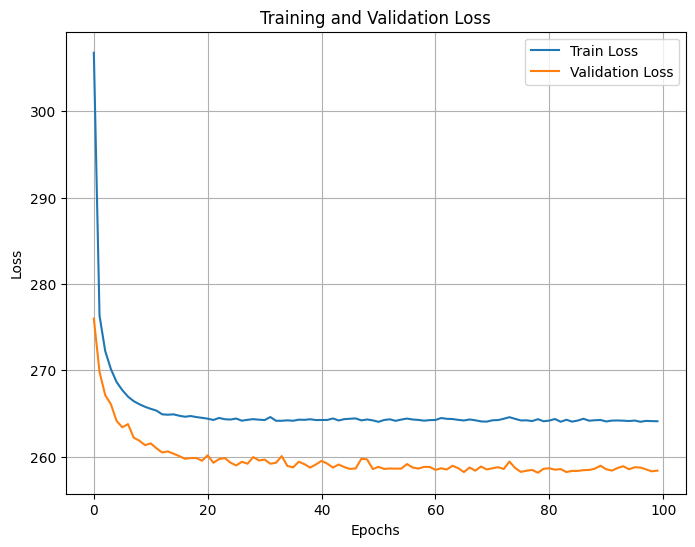

In [ ]:
# Параметри
latent_dim = 3  # Збільшили розмір латентного простору
intermediate_dim = 256
input_shape = (28, 28, 1)

# Енкодер
inputs = Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dropout(0.3)(x)  # Додано Dropout
x = BatchNormalization()(x)  # Додано BatchNormalization
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Репараметризація
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Декодер
decoder_input = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(decoder_input)
x = Dropout(0.3)(x)  # Додано Dropout
x = Dense(28 * 28, activation='sigmoid')(x)
outputs = Reshape((28, 28, 1))(x)

decoder = Model(decoder_input, outputs)
vae_outputs = decoder(z)

# Шар для втрат
class VAE_LossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAE_LossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, z_mean, z_log_var, outputs = inputs
        reconstruction_loss = tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x, outputs), axis=[1, 2]
        )
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        )
        self.add_loss(tf.reduce_mean(reconstruction_loss + kl_loss))
        return outputs

vae_outputs = VAE_LossLayer()([inputs, z_mean, z_log_var, vae_outputs])
vae = Model(inputs, vae_outputs)
vae.compile(optimizer='adam')

# Логи для втрат
history = vae.fit(x_train, x_train,
        epochs=100,
        batch_size=128,
        validation_split=0.1)

# Графік втрат
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

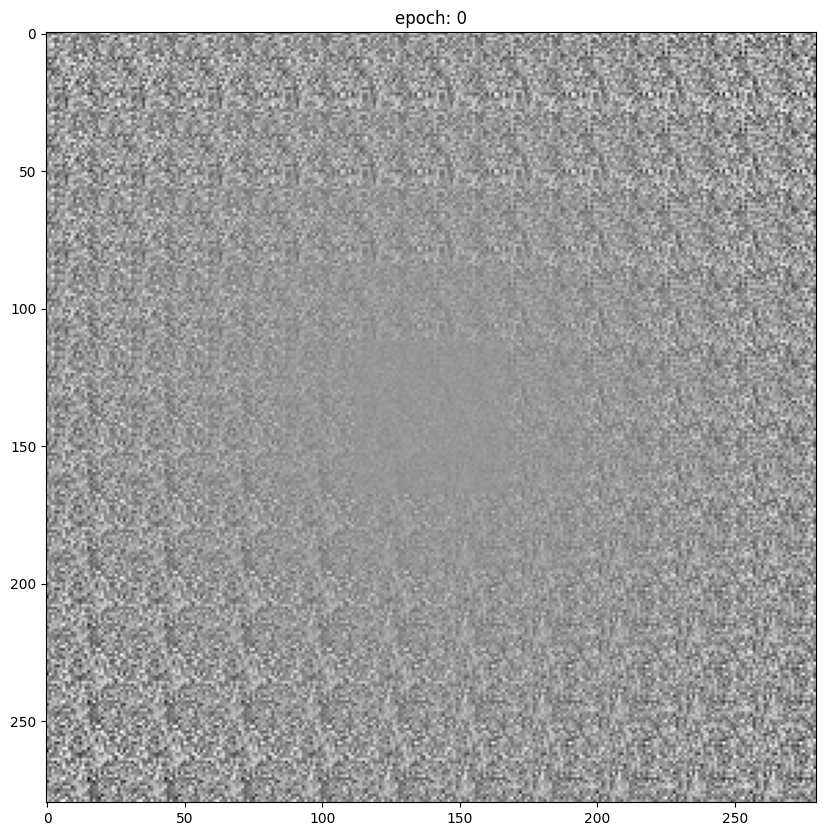

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 347.6241 - val_loss: 276.2886
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 278.0157 - val_loss: 270.5734
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 274.2636 - val_loss: 267.4620
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 271.1246 - val_loss: 265.8477
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 269.0279 - val_loss: 264.8583
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 268.4121 - val_loss: 263.5760
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 267.4028 - val_loss: 263.4433
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 266.8054 - val_loss: 262.2342
Epoch 9/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 267.0507 - val_loss: 262.9897
Epoch 10/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.8377 - val_loss: 261.9578
Epoch 11/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.8716 - val_loss: 261.2374
Epoch 1

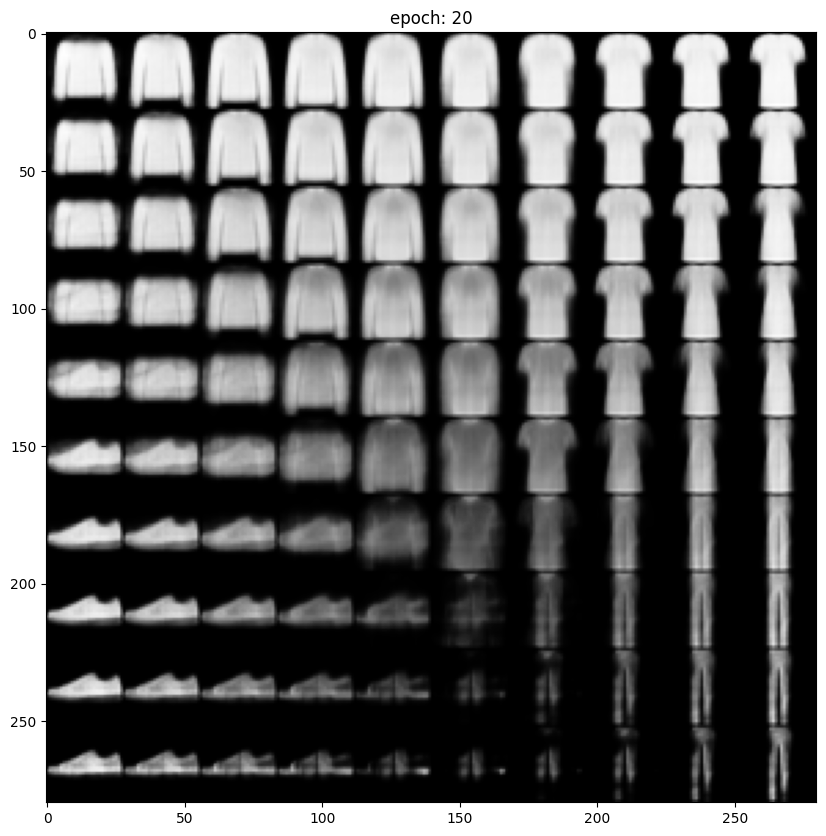

Epoch 1/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 264.4880 - val_loss: 260.4718
Epoch 2/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.1914 - val_loss: 259.5885
Epoch 3/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.9597 - val_loss: 259.6247
Epoch 4/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.1956 - val_loss: 260.2119
Epoch 5/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.2322 - val_loss: 260.1225
Epoch 6/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.6506 - val_loss: 259.7532
Epoch 7/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.9950 - val_loss: 259.5081
Epoch 8/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.1471 - val_loss: 259.7593
Epoch 9/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.6161 - val_loss: 259.8781
Epoch 10/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 265.4210 - val_loss: 259.8603
Epoch 11/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.6746 - val_loss: 259.5870
Epoch 12

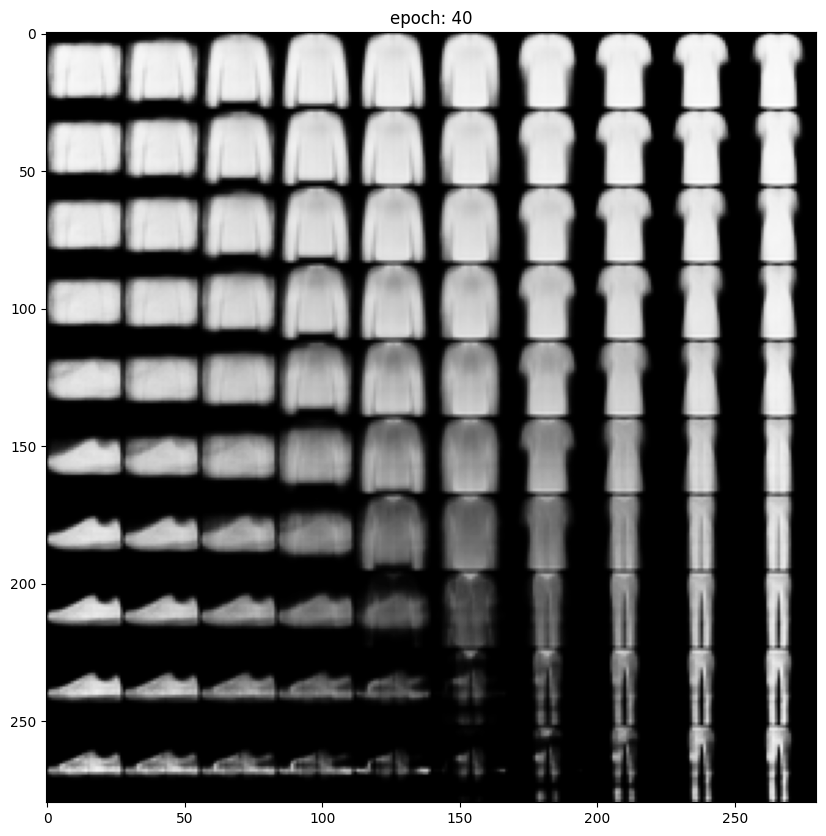

Epoch 1/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 265.1877 - val_loss: 259.5179
Epoch 2/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.4973 - val_loss: 258.6629
Epoch 3/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.2886 - val_loss: 259.0405
Epoch 4/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.7735 - val_loss: 258.8038
Epoch 5/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.2575 - val_loss: 259.1134
Epoch 6/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.2251 - val_loss: 258.5212
Epoch 7/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.1319 - val_loss: 258.4074
Epoch 8/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.1898 - val_loss: 258.3544
Epoch 9/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.5058 - val_loss: 258.9835
Epoch 10/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.3244 - val_loss: 258.9059
Epoch 11/60
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.5078 - val_loss: 258.7947
Epoch 12

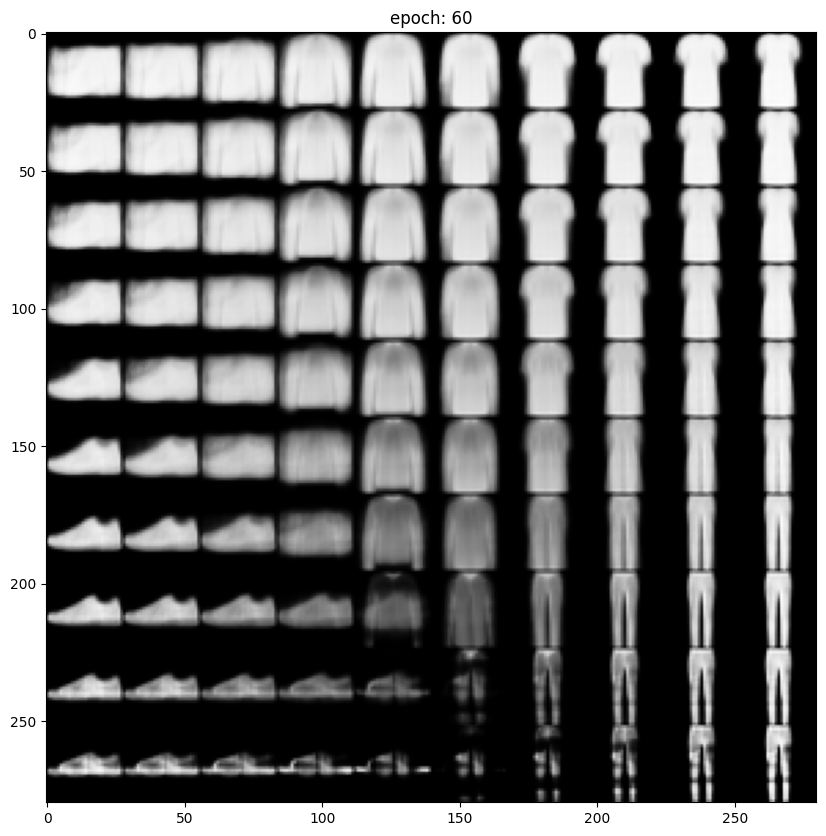

Epoch 1/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 264.5965 - val_loss: 258.8702
Epoch 2/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.8108 - val_loss: 258.2995
Epoch 3/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.9804 - val_loss: 258.4165
Epoch 4/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 263.7785 - val_loss: 258.5844
Epoch 5/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.0649 - val_loss: 258.7339
Epoch 6/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.4666 - val_loss: 258.2478
Epoch 7/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.0732 - val_loss: 258.5185
Epoch 8/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.2305 - val_loss: 258.6844
Epoch 9/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.7615 - val_loss: 258.0881
Epoch 10/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.3681 - val_loss: 258.3740
Epoch 11/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.6823 - val_loss: 258.4638
Epoch 12

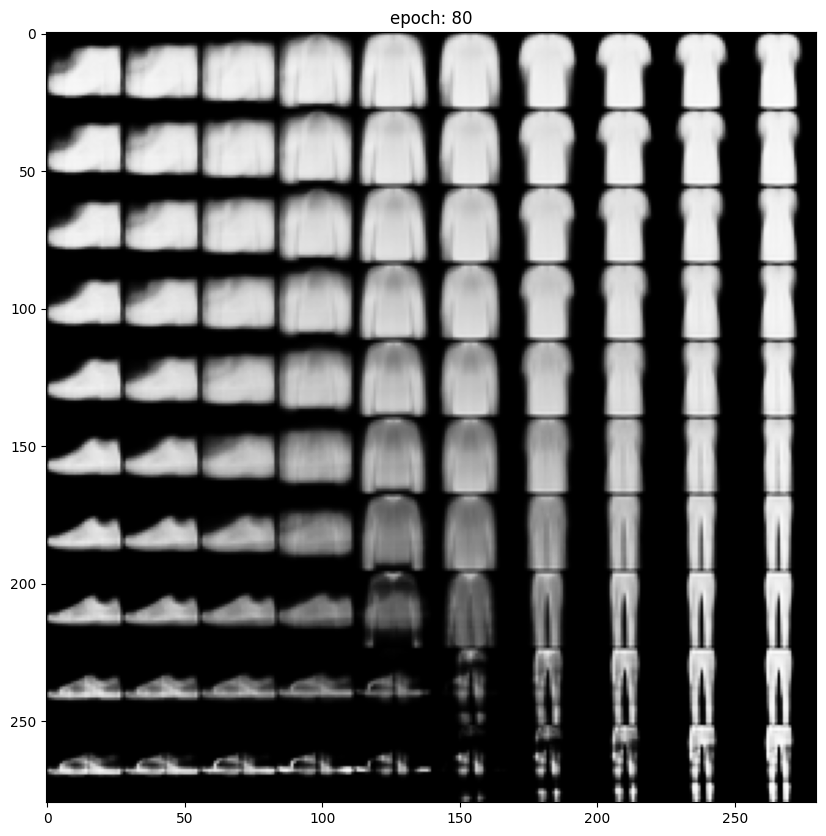

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 264.1942 - val_loss: 257.8039
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.4254 - val_loss: 258.0672
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 263.7733 - val_loss: 258.3337
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.1106 - val_loss: 258.2447
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 262.8945 - val_loss: 258.2943
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 263.9742 - val_loss: 258.2248
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.0124 - val_loss: 257.9855
Epoch 8/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 263.9772 - val_loss: 258.0299
Epoch 9/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.9250 - val_loss: 258.8369
Epoch 10/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.3655 - val_loss: 258.1254
Epoch 11/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 264.2406 - val_loss: 257.88

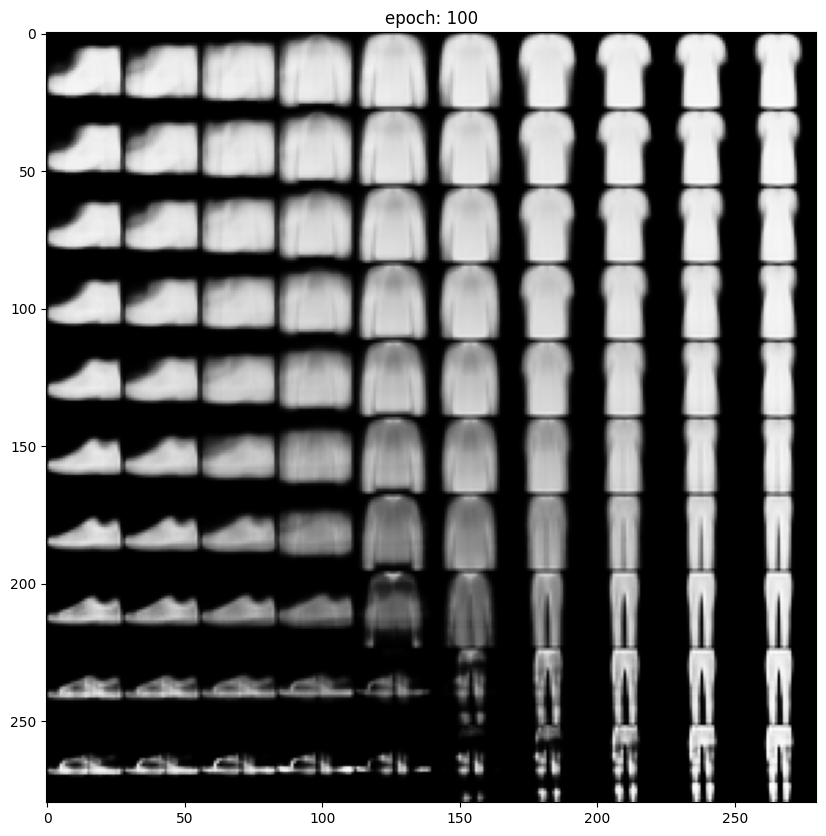

In [ ]:
# Навчання моделі
for epoch in range(0, 101, 20):
    vae.fit(x_train, x_train,
            epochs=epoch,
            batch_size=128,
            validation_split=0.1)

    # Генерація зображень
    n = 10
    figure = np.zeros((28 * n, 28 * n))
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi, 0]])  # Додали 3-ю координату в латентному просторі
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.title(f'epoch: {epoch}')
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<ipython-input-45-68fb0de6ac51>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c='blue', cmap='tab10', alpha=0.5)


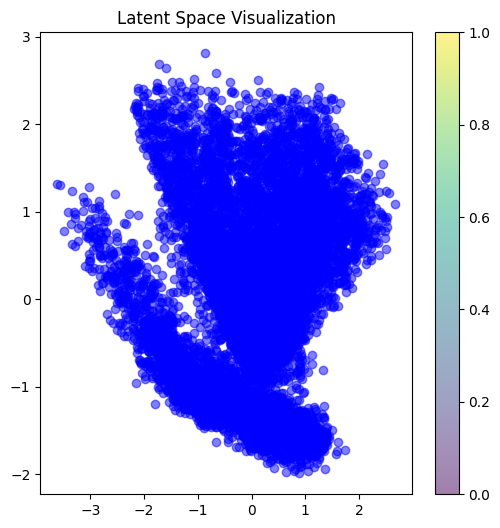

In [ ]:
# Візуалізація латентного простору
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(x_test)
plt.figure(figsize=(6, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c='blue', cmap='tab10', alpha=0.5)
plt.colorbar()
plt.title('Latent Space Visualization')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


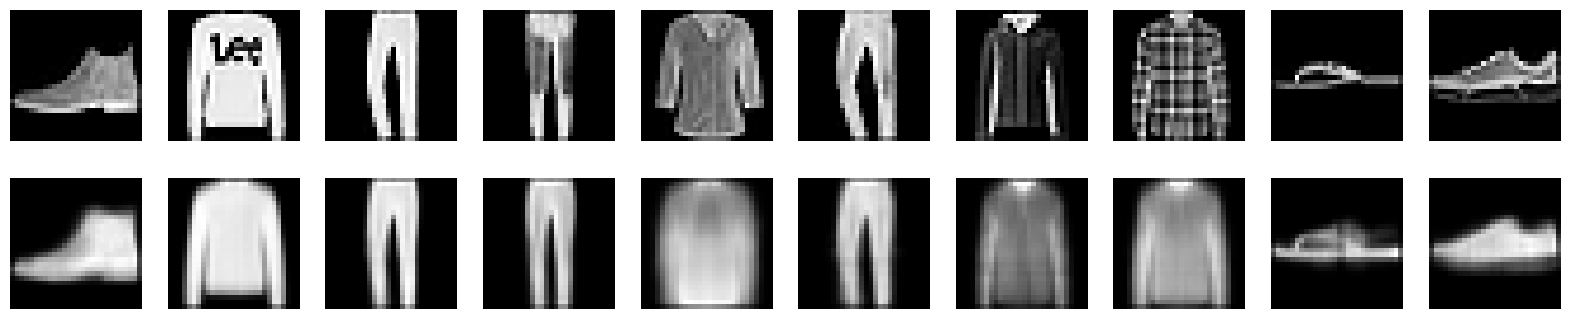

In [ ]:
# Порівняння оригінальних та відновлених зображень
def plot_reconstructions():
    n = 10
    decoded_imgs = vae.predict(x_test[:n])

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Оригінал
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Відновлене
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

plot_reconstructions()